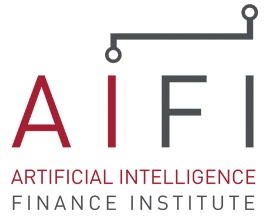


# Bootcamp - Python and Coding - Deep Learning

# TensorFlow Functional vs. Sequential API

# About this Notebook

This is an introduction to the functional API from `TensorFlow`. The Keras functional API is a way to create models that are more flexible than the tf.keras.Sequential API. The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

The main idea is that a deep learning model is usually a directed acyclic graph (DAG) of layers. So the functional API is a way to build graphs of layers. For more information see the [TensorFlow documentation](https://www.tensorflow.org/guide/keras/functional). 

This example is taken from my paper: [Dynamic and Context-Dependent Stock Price Prediction Using Attention Modules and News Sentiment](https://arxiv.org/abs/2205.01639)

<table><tr>
<td> <img src="../../resources/sequential_model_plot.png" alt="Drawing" style="width: 550px;"/> </td>
<td> <img src="../../resources/functional_model_plot.png" alt="Drawing" style="width: 950px;"/> </td>
</tr></table>

To visualize the model simply use after initializing the model the following: `plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)`

# Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import matplotlib.cm as cm
from importlib import reload


# to make this notebook's output stable across runs 
import random
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# custom library with functions
py_file_location = '../../'
sys.path.append(os.path.abspath(py_file_location)) # for accessing the path

from customlib import preprocessing as pre
from customlib import plotting


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# custom class for alpha_t-RIM
py_file_location = '../../customlib/'
sys.path.append(os.path.abspath(py_file_location)) # for accessing the path
from att_visualization import RIMCell, RIMCell2

# Computing environment
<a id="Versions" > 

In [2]:
%reload_ext watermark
%watermark -a "Author: Nicole Königstein" 
%watermark -d -v -m 
%watermark -v -p numpy,matplotlib,pandas,seaborn


Author: Author: Nicole Königstein

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

Compiler    : Clang 13.1.6 (clang-1316.0.21.2)
OS          : Darwin
Release     : 21.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

numpy     : 1.22.4
matplotlib: 3.5.2
pandas    : 1.4.3
seaborn   : 0.11.1



This notebook is just for demonstration purposes to demotrate how the layer can be extracted from the $\alpha_{t}$-RIM model. 

In [3]:
PATH = '../../'
# get the considered stock
data = pd.read_csv(PATH + 'data/feature_df_selected.csv')
# convert date object to datetime
format = '%Y-%m-%d'
data['date'] = pd.to_datetime(data['date'], format=format)
data.set_index('date',inplace=True)

df = data.loc[data['ticker']=='BF_B']


In [4]:
df = data.loc[data['ticker']=='BF_B']
df = df[['close']]
#data = data[['close']]
df.head() # show features

,close
date,
2015-01-02,32.197535
2015-01-05,32.197535
2015-01-06,32.197535
2015-01-07,32.197535
2015-01-08,32.690630


In [5]:
use_features = ['close'] # continuous input
target = ['close'] # continuous output
n_steps_ahead = 5 # forecasting horizon

# Data preparation

In [6]:
mu, sigma, df_train,  df_test = pre.prepare_data(df)

# 5 lags input

In [7]:
n_steps = 5
n_steps_ahead = 5

We split the data differntly, because it is harder to extract it with the not continuous output. 

In [8]:
x_train = pre.get_lagged_features(df_train[use_features], n_steps, n_steps_ahead)
y_train = df_train[target].values[n_steps + n_steps_ahead - 1:]

x_test = pre.get_lagged_features(df_test[use_features], n_steps, n_steps_ahead)
y_test = df_test[target].values[n_steps + n_steps_ahead - 1:]

print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(1286, 5, 1), (1286, 1), (315, 5, 1), (315, 1)]


# Build functional model

In [9]:
input_size = x_train.shape[-1]

In [10]:
rnn_cell2 = RIMCell2(units=16, nRIM=14, k=10,
                num_input_heads=input_size, input_key_size=10, input_value_size=12, 
                input_query_size=10, input_keep_prob=0.9,num_comm_heads=8, 
                comm_key_size=4, comm_value_size=8, comm_query_size=4, comm_keep_prob=0.7)

## Compile the model

In [11]:
rnn_layer = tf.keras.layers.RNN(cell=rnn_cell2, return_sequences = False, return_state=False)

inputs = tf.keras.Input(shape=(n_steps, input_size))
rnn_output = rnn_layer(inputs)
dense_output = tf.keras.layers.Dense(n_steps_ahead)(rnn_output['output'])

model = tf.keras.Model(inputs = inputs, outputs = dense_output)
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, min_delta=3e-5, restore_best_weights=True)

metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse'),'mae']
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=metrics)
model.summary()

2022-08-06 09:57:05.984894: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 1)]            0         
                                                                 
 rnn (RNN)                   {'topk': TopKV2(values=(  57836     
                             None, 10),                          
                              indices=(None, 10)),               
                              'sparse_tensor': (None,            
                              None),                             
                              'mask': (None, None, 1)            
                             , 'attention_prob': (Non            
                             e, 14, 2),                          
                              'inputs_attention': (No            
                             ne, 14, 12),                        
                              'inputs1': (None, 14, 1        

In [12]:
x_train.shape

(1286, 5, 1)

## Train the model

In [13]:
max_epochs = 2000

history = model.fit(x_train,y_train, epochs=max_epochs,verbose=True, callbacks=es).history

Epoch 1/2000
41/41 [==============================] - 4s 14ms/step - loss: 0.3332 - rmse: 0.5772 - mae: 0.4258
Epoch 2/2000
41/41 [==============================] - 1s 14ms/step - loss: 0.0251 - rmse: 0.1584 - mae: 0.1206
Epoch 3/2000
41/41 [==============================] - 1s 14ms/step - loss: 0.0237 - rmse: 0.1540 - mae: 0.1167
Epoch 4/2000
41/41 [==============================] - 1s 14ms/step - loss: 0.0236 - rmse: 0.1535 - mae: 0.1164
Epoch 5/2000
41/41 [==============================] - 1s 16ms/step - loss: 0.0227 - rmse: 0.1508 - mae: 0.1150
Epoch 6/2000
41/41 [==============================] - 1s 14ms/step - loss: 0.0220 - rmse: 0.1483 - mae: 0.1128
Epoch 7/2000
41/41 [==============================] - 1s 14ms/step - loss: 0.0226 - rmse: 0.1505 - mae: 0.1144
Epoch 8/2000
41/41 [==============================] - 1s 14ms/step - loss: 0.0226 - rmse: 0.1504 - mae: 0.1136
Epoch 9/2000
41/41 [==============================] - 1s 14ms/step - loss: 0.0223 - rmse: 0.1494 - mae: 0.1131
E

## Feature Extractor

In [14]:
topk_extractor = tf.keras.Model(inputs = inputs, outputs = [rnn_output['topk'], rnn_output['inputs1'], rnn_output['attention_prob'], rnn_output['inputs_attention'] ])
topk_tensors, inputs1_tensors, attention_prob_tensors, inputs_attention_tensors = topk_extractor.predict(x_test[:100])


In [15]:
model.evaluate(x_test, y_test)


10/10 [==============================] - 1s 10ms/step - loss: 0.0704 - rmse: 0.2653 - mae: 0.2163


[0.07038366049528122, 0.2652992010116577, 0.21633048355579376]

## Feature Extractor Plots

* The way to do it would be: get attention values for how each module is relevant at each particular time-step.
* Look at the weights at each time-step and module and then use the ones with the highest weight as the activated ones and the others as deactivated ones. Meaning, look at the topk attention weights

(100, 14, 12)


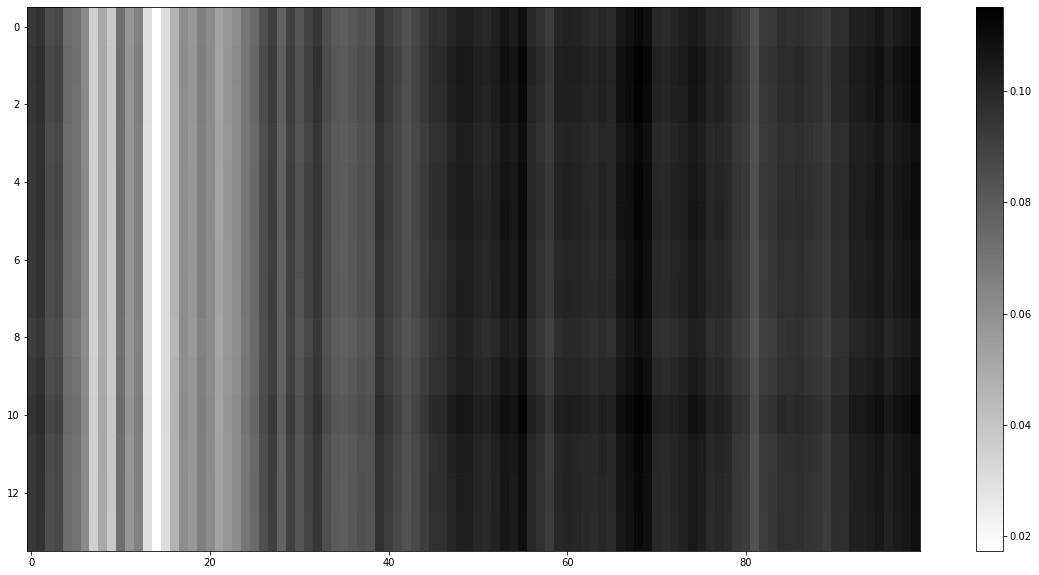

In [16]:
print(inputs_attention_tensors.shape)
plt.figure(figsize=(20,10))
inputs_attention_condensed = tf.reduce_mean(inputs_attention_tensors, axis=[2])
plt.imshow(inputs_attention_condensed.numpy().T,cmap='binary', aspect='auto')
plt.colorbar();

(100, 14, 2)


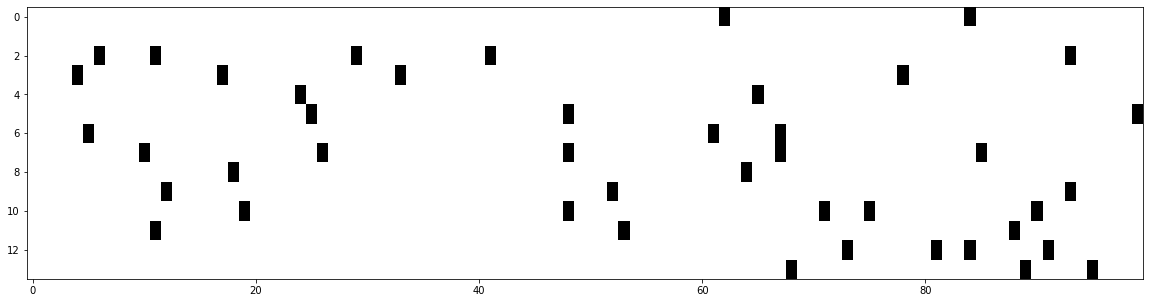

In [17]:
print(attention_prob_tensors.shape)
plt.figure(figsize=(20,5))
attention_prob_condensed = np.where(tf.reduce_mean(attention_prob_tensors, axis=[2]).numpy()>0.5,1,0)
plt.imshow(attention_prob_condensed.T,cmap='binary', aspect='auto');

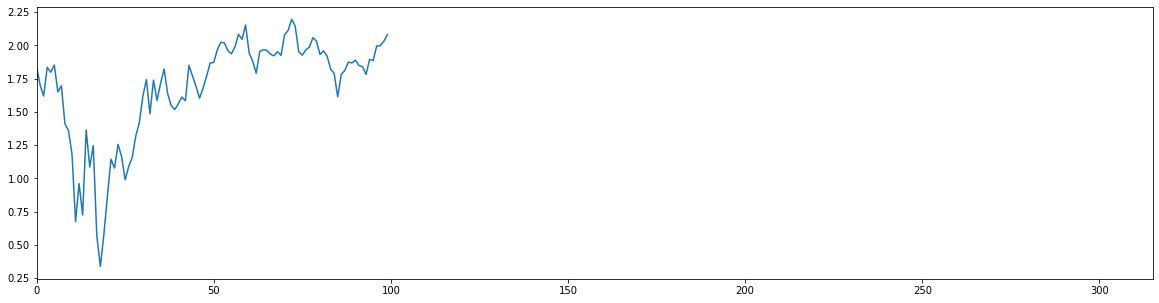

In [18]:
plt.figure(figsize=(20,5))
plt.xlim(0, np.min(x_test.shape[0]))
plt.plot(x_test[:100,0]);

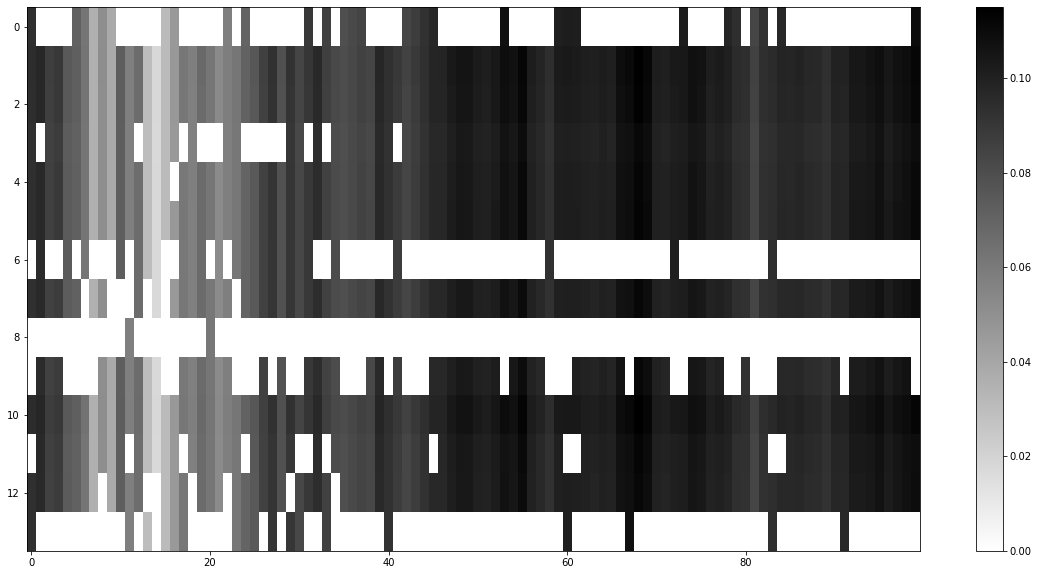

In [19]:
plt.figure(figsize=(20,10))
inputs1_tensors_condensed = tf.reduce_mean(inputs1_tensors, axis=[2])
plt.imshow(inputs1_tensors_condensed.numpy().T,cmap='binary', aspect='auto')
plt.colorbar();

In [20]:
topk_tensors.indices.shape

(100, 10)

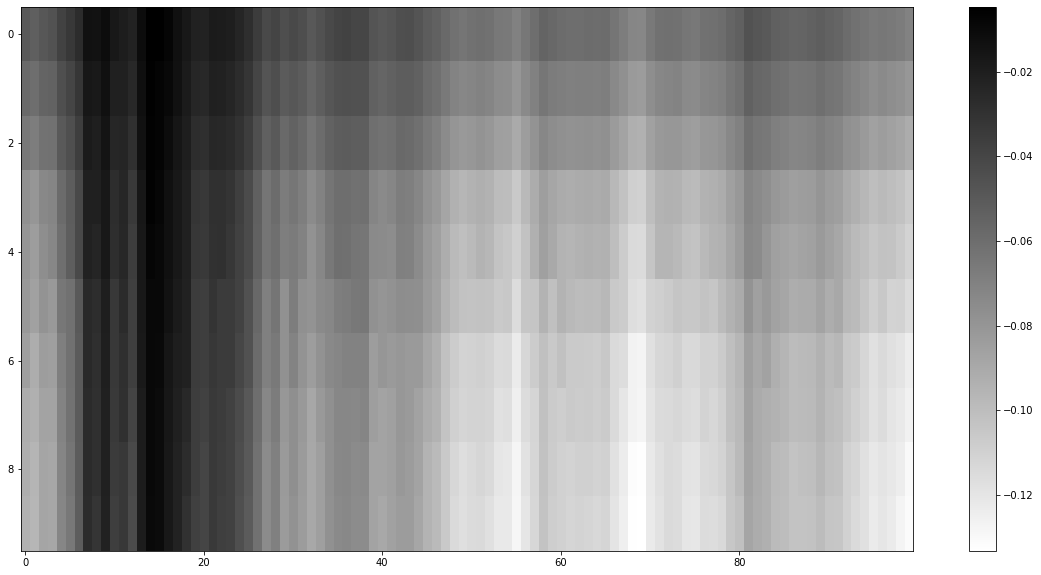

In [21]:
plt.figure(figsize=(20,10))
plt.imshow(topk_tensors.values.T, cmap='binary',aspect='auto')
plt.colorbar();


# Bivariate input

In [22]:
df = data.loc[data['ticker']=='BF_B']
df = df[['close','conv_filter']]
#data = data[['close']]
df.head() # show features

,close,conv_filter
date,,
2015-01-02,32.197535,0.736203
2015-01-05,32.197535,0.736203
2015-01-06,32.197535,0.733010
2015-01-07,32.197535,0.743926
2015-01-08,32.690630,0.754841


In [23]:
use_features = ['close','conv_filter'] # continuous input
target = ['close'] # continuous output
n_steps_ahead = 5 # forecasting horizon

# Data preparation

In [24]:
mu, sigma, df_train,  df_test = pre.prepare_data(df)

In [25]:
n_steps = 5
n_steps_ahead = 5

In [26]:

x_train = pre.get_lagged_features(df_train[use_features], n_steps, n_steps_ahead)
y_train =  df_train[target].values[n_steps + n_steps_ahead - 1:]

x_test = pre.get_lagged_features(df_test[use_features], n_steps, n_steps_ahead)
y_test =  df_test[target].values[n_steps + n_steps_ahead - 1:]

print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(1286, 5, 2), (1286, 1), (315, 5, 2), (315, 1)]


In [27]:
input_size = x_train.shape[-1]
rnn_cell3 = RIMCell2(units=16, nRIM=14, k=10,
                num_input_heads=input_size, input_key_size=10, input_value_size=12, 
                input_query_size=10, input_keep_prob=0.9,num_comm_heads=8, 
                comm_key_size=4, comm_value_size=12, comm_query_size=4, comm_keep_prob=0.7)

## Compile the model

In [28]:
rnn_layer = tf.keras.layers.RNN(cell=rnn_cell3, return_sequences = False, return_state=False)

inputs = tf.keras.Input(shape=(n_steps, input_size))
rnn_output = rnn_layer(inputs)
dense_output = tf.keras.layers.Dense(n_steps_ahead)(rnn_output['output'])

model_2 = tf.keras.Model(inputs = inputs, outputs = dense_output)
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, min_delta=3e-5, restore_best_weights=True)

metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse'),'mae']
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_2.compile(optimizer=opt, loss='mean_squared_error', metrics=metrics)
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 2)]            0         
                                                                 
 rnn_1 (RNN)                 {'topk': TopKV2(values=(  74500     
                             None, 10),                          
                              indices=(None, 10)),               
                              'sparse_tensor': (None,            
                              None),                             
                              'mask': (None, None, 1)            
                             , 'attention_prob': (Non            
                             e, 14, 2),                          
                              'inputs_attention': (No            
                             ne, 14, 12),                        
                              'inputs1': (None, 14, 1      

## Train the model

In [29]:
max_epochs = 2000

history_2 = model_2.fit(x_train,y_train, epochs=max_epochs,verbose=True, callbacks=es).history

Epoch 1/2000
41/41 [==============================] - 4s 25ms/step - loss: 0.4747 - rmse: 0.6890 - mae: 0.5440
Epoch 2/2000
41/41 [==============================] - 1s 27ms/step - loss: 0.0281 - rmse: 0.1675 - mae: 0.1279
Epoch 3/2000
41/41 [==============================] - 1s 26ms/step - loss: 0.0244 - rmse: 0.1562 - mae: 0.1193
Epoch 4/2000
41/41 [==============================] - 1s 27ms/step - loss: 0.0238 - rmse: 0.1544 - mae: 0.1181
Epoch 5/2000
41/41 [==============================] - 1s 27ms/step - loss: 0.0252 - rmse: 0.1588 - mae: 0.1223
Epoch 6/2000
41/41 [==============================] - 1s 29ms/step - loss: 0.0234 - rmse: 0.1529 - mae: 0.1165
Epoch 7/2000
41/41 [==============================] - 1s 31ms/step - loss: 0.0243 - rmse: 0.1558 - mae: 0.1188
Epoch 8/2000
41/41 [==============================] - 1s 26ms/step - loss: 0.0221 - rmse: 0.1486 - mae: 0.1124
Epoch 9/2000
41/41 [==============================] - 1s 26ms/step - loss: 0.0228 - rmse: 0.1509 - mae: 0.1157
E

## Feature Extractor

In [30]:
topk_extractor_2 = tf.keras.Model(inputs = inputs, outputs = [rnn_output['topk'], rnn_output['inputs1'], rnn_output['attention_prob'], rnn_output['inputs_attention'] ])
topk_tensors_2, inputs1_tensors_2, attention_prob_tensors_2, inputs_attention_tensors_2 = topk_extractor_2.predict(x_test[:100])



In [31]:
model_2.evaluate(x_test, y_test)

10/10 [==============================] - 1s 14ms/step - loss: 0.0931 - rmse: 0.3051 - mae: 0.2606


[0.09307599812746048, 0.30508360266685486, 0.26061248779296875]

## Feature Extractor Plots

* The way to do it would be: get attention values for how each module is relevant at each particular time-step.
* Look at the weights at each time-step and module and then use the ones with the highest weight as the activated ones and the others as deactivated ones. Meaning, look at the topk attention weights

(100, 14, 12)


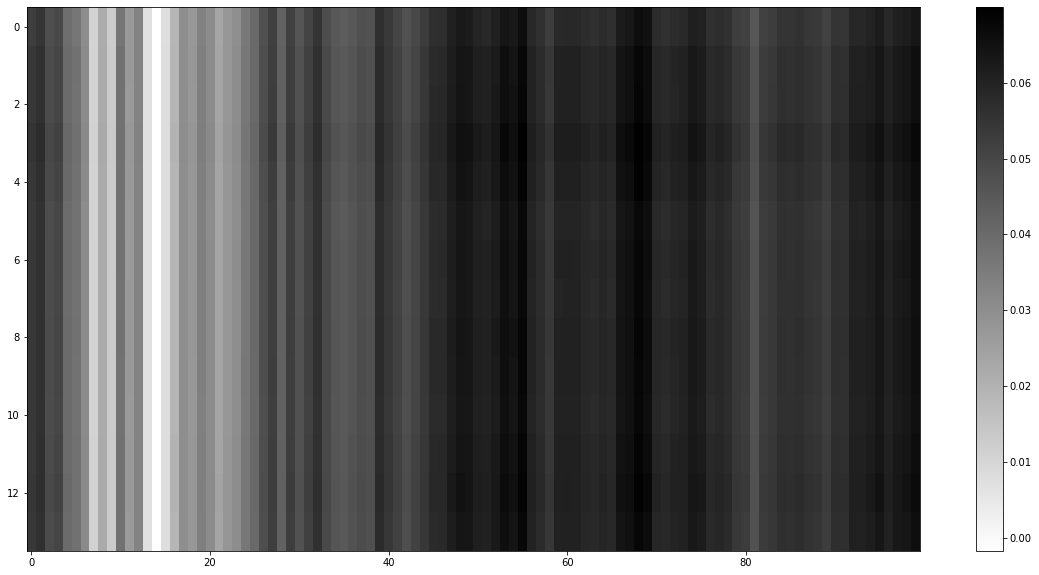

In [32]:
print(inputs_attention_tensors_2.shape)
plt.figure(figsize=(20,10))
inputs_attention_condensed = tf.reduce_mean(inputs_attention_tensors_2, axis=[2])
plt.imshow(inputs_attention_condensed.numpy().T,cmap='binary', aspect='auto')
plt.colorbar();

(100, 14, 2)


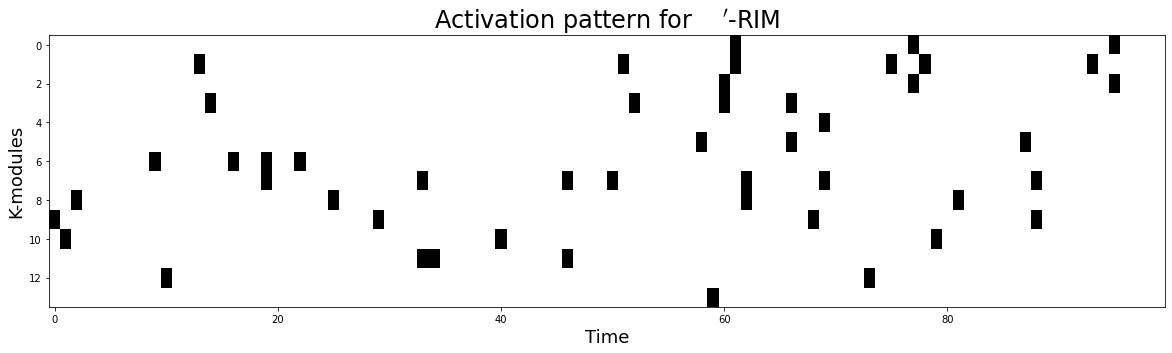

In [33]:
print(attention_prob_tensors.shape)
plt.figure(figsize=(20,5))
attention_prob_condensed_2 = np.where(tf.reduce_mean(attention_prob_tensors_2, axis=[2]).numpy()>0.5,1,0)
plt.imshow(attention_prob_condensed_2.T,cmap='binary', aspect='auto')
plt.xlabel('Time',fontsize=18)
plt.ylabel('K-modules',fontsize=18)
plt.title("Activation pattern for    $ '\alpha_{t}$-RIM",fontsize=24);
#plt.imshow(attention_prob_condensed.T,cmap='Reds', aspect='auto');
#plt.colorbar();

In [34]:
inputs1_tensors.shape

(100, 14, 12)

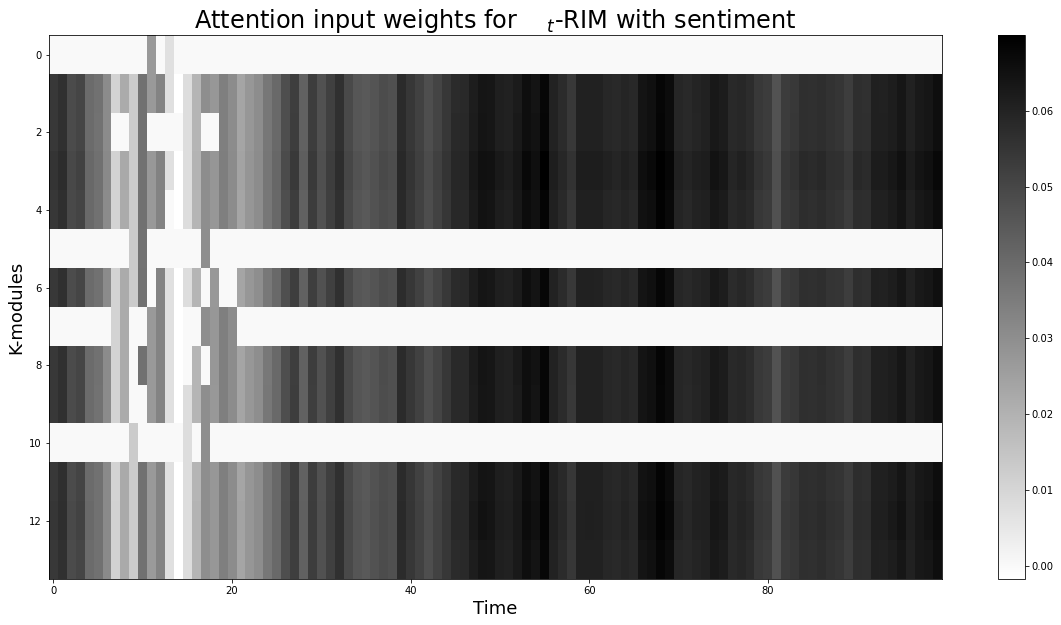

In [35]:
plt.figure(figsize=(20,10))
inputs1_tensors_condensed = tf.reduce_mean(inputs1_tensors_2, axis=[2])
plt.imshow(inputs1_tensors_condensed.numpy().T,cmap='binary', aspect='auto')
plt.colorbar()
plt.xlabel('Time',fontsize=18)
plt.ylabel('K-modules',fontsize=18)
plt.title('Attention input weights for    $ _{t}$-RIM with sentiment',fontsize=24);

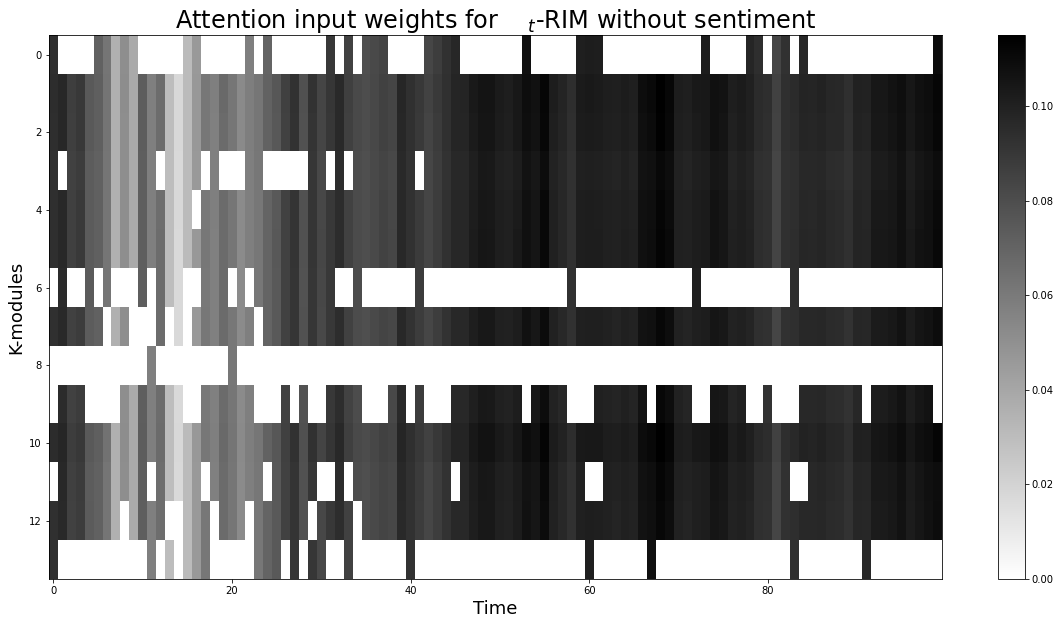

In [36]:
plt.figure(figsize=(20,10))
inputs1_tensors_condensed = tf.reduce_mean(inputs1_tensors, axis=[2])
plt.imshow(inputs1_tensors_condensed.numpy().T,cmap='binary', aspect='auto')
plt.xlabel('Time',fontsize=18)
plt.ylabel('K-modules',fontsize=18)
plt.title('Attention input weights for    $ _{t}$-RIM without sentiment',fontsize=24);
plt.colorbar(); 

In [37]:
topk_tensors.indices.shape

(100, 10)

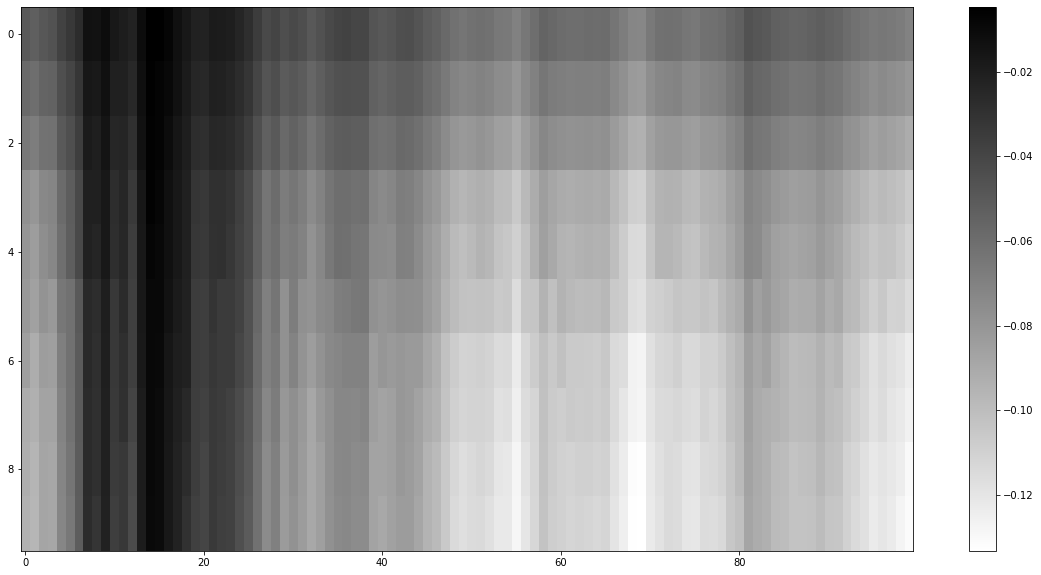

In [38]:
plt.figure(figsize=(20,10))
plt.imshow(topk_tensors.values.T, cmap='binary',aspect='auto')
plt.colorbar();
